# Use-case: Deconvoluting drug responses in cancer cell lines 

This tutorial shows how to perform the analysis we present in Figure 3 of the [pertpy preprint](https://www.biorxiv.org/content/10.1101/2024.08.04.606516v1). We will use the [McFarland et al. 2020](https://doi.org/10.1038/s41467-020-17440-w) dataset, which contains single-cell RNA-seq data from 172 cancer cell lines treated with 13 drugs. We will first preprocess the data, annotate it with metadata, and compare it to bulk RNA-seq data. We will then deconvolute the drug response of each cell line into viability-dependent and -independent components.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pertpy as pt
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Load and preprocess data

In [2]:
adata = pt.dt.mcfarland_2020()
adata

AnnData object with n_obs × n_vars = 182875 × 32738
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells'

We only want to look at the drug perturbations in this analysis, so we will filter out cells that were treated with other perturbations.

In [3]:
adata = adata[adata.obs["perturbation_type"] == "drug"]
adata

View of AnnData object with n_obs × n_vars = 154710 × 32738
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells'

We will now perform some standard preprocessing steps on the data, such as filtering out low-quality cells, normalizing the data, and identifying highly variable genes. As we will use EdgeR for differential expression analysis, which requires raw counts, we will also save the raw counts in the `raw_counts` layer.

In [4]:
sc.pp.filter_genes(adata, min_cells=30)

adata.layers["raw_counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, subset=True, n_top_genes=4000)

/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy-env/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:275: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


         Falling back to preprocessing with `sc.pp.pca` and default params.


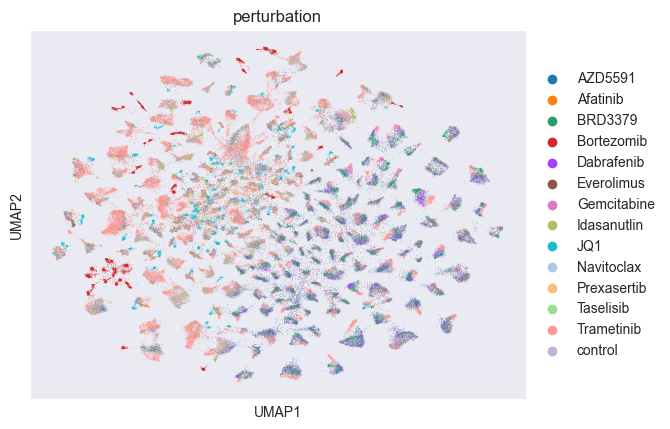

In [5]:
sc.pp.neighbors(adata)
sc.pp.pca(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="perturbation")

## Metadata annotation
Pertpy offers multiple metadata classes to annotate your data. Here, we will use the `CellLine` and `Moa` classes to annotate the cell lines and mechanisms of action (MOA) of the drugs, respectively.

In [6]:
cl_metadata = pt.md.CellLine()
cl_metadata.annotate(
    adata,
    query_id="DepMap_ID",
    reference_id="ModelID",
    fetch=["CellLineName", "Age", "OncotreePrimaryDisease", "SangerModelID", "OncotreeLineage"],
)

AnnData object with n_obs × n_vars = 154710 × 4000
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'CellLineName', 'Age', 'OncotreePrimaryDisease', 'SangerModelID', 'OncotreeLineage'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'neighbors', 'pca', 'umap', 'perturbation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts'
    obsp: 'distances', 'connectivities'

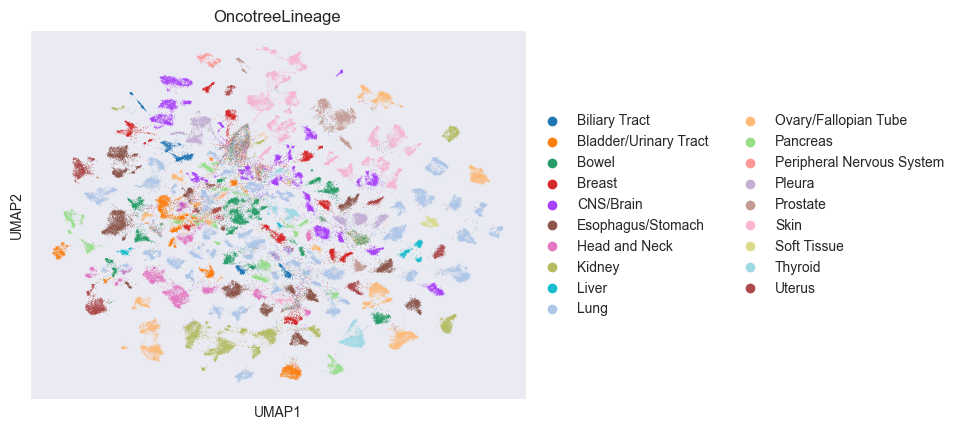

In [7]:
sc.pl.umap(adata, color=["OncotreeLineage"])

In [8]:
moa_metadata = pt.md.Moa()
moa_metadata.annotate(
    adata,
    query_id="perturbation",
)

# Add control annotations
adata.obs["moa"] = ["Control" if pert == "control" else moa for moa, pert in zip(adata.obs["moa"], adata.obs["perturbation"])]
adata.obs["target"] = ["Control" if pert == "control" else target for target, pert in zip(adata.obs["target"], adata.obs["perturbation"])]

💡 There are 14 identifiers in `adata.obs`.However, 5 identifiers can't be found in the moa annotation,leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...


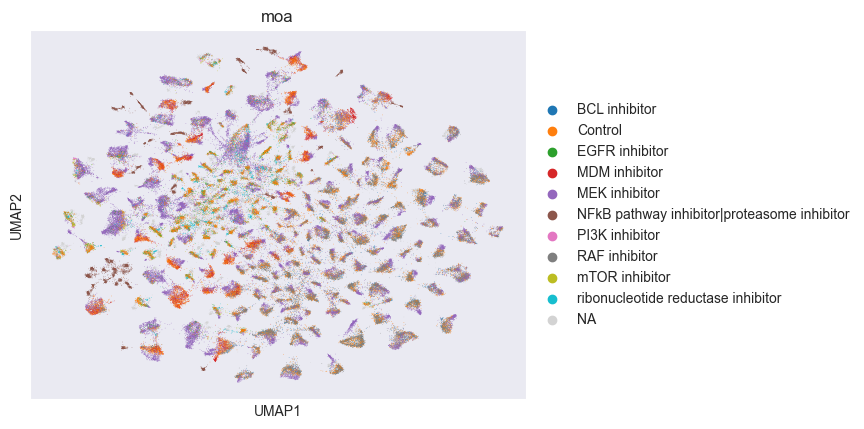

In [9]:
sc.pl.umap(adata, color=["moa"])

Next, we will annotate the dataset with GDSC IC50 values, which indicate the drug response of each cell line to each drug. We will use the `GDSC` class for this purpose. Note that we will use the previously queried `SangerModelID` as cell line name for this step. There are two versions of the dataset: GDSC1 and GDSC2. We will annotate the dataset with both versions.


In [10]:
cl_metadata.annotate_from_gdsc(
    adata,
    query_id="SangerModelID",
    reference_id="sanger_model_id",
    query_perturbation='perturbation',
    gdsc_dataset="gdsc_1",
)
adata.obs["ln_ic50_GDSC1"] = adata.obs["ln_ic50"].copy()

cl_metadata.annotate_from_gdsc(
    adata,
    query_id="SangerModelID",
    reference_id="sanger_model_id",
    query_perturbation='perturbation',
    gdsc_dataset="gdsc_2",
)
adata.obs["ln_ic50_GDSC2"] = adata.obs["ln_ic50"].copy()

del adata.obs["ln_ic50"]
adata

💡 There are 140 identifiers in `adata.obs`.However, 25 identifiers can't be found in the drug response annotation,leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...
💡 There are 140 identifiers in `adata.obs`.However, 25 identifiers can't be found in the drug response annotation,leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...


AnnData object with n_obs × n_vars = 154710 × 4000
    obs: 'SangerModelID', 'perturbation', 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'CellLineName', 'Age', 'OncotreePrimaryDisease', 'OncotreeLineage', 'moa', 'target', 'ln_ic50_GDSC1', 'ln_ic50_GDSC2'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'neighbors', 'pca', 'umap', 'perturbation_colors', 'OncotreeLineage_colors', 'moa_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers:

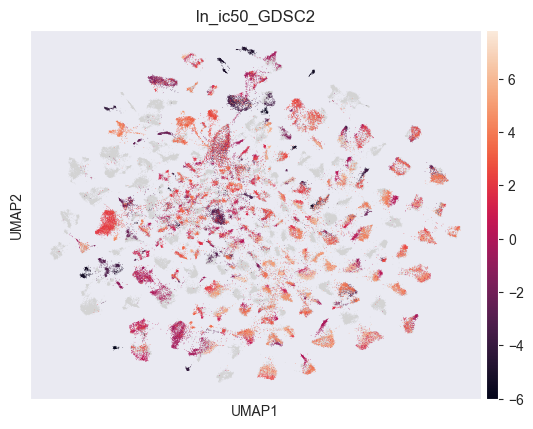

In [11]:
sc.pl.umap(adata, color=["ln_ic50_GDSC2"])

## Comparison to bulk RNA-seq data

One question we might have after sequencing an in vitro experiment is “How similar are our expression profiles compared to the public database?” To answer this, we generate “pseudobulks” by aggregating counts to the cell-type level and then compare them with bulk RNA-seq data.

In [12]:
ps = pt.tl.PseudobulkSpace()
pdata = ps.compute(adata, target_col="CellLineName", groups_col="perturbation")

In [13]:
base_line = pdata[pdata.obs.perturbation == "control"]
base_line.obs.index = base_line.obs.index.str.replace("_control", "")

In [14]:
cl_metadata.annotate_bulk_rna(base_line, cell_line_source="broad", query_id="DepMap_ID")

❗ To annotate bulk RNA data from Broad Institue, `DepMap_ID` is used as default reference and query identifier if no `reference_id` is given.
Ensure that `DepMap_ID` is available in 'adata.obs'.
Alternatively, use `annotate()` to annotate the cell line first 
💡 There are 170 identifiers in `adata.obs`.However, 1 identifiers can't be found in the bulk RNA annotation,leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...


/Users/mamba/PycharmProjects/pertpy/pertpy/metadata/_cell_line.py:400: ImplicitModificationWarning: Setting element `.obsm['bulk_rna_broad']` of view, initializing view as actual.
  adata.obsm["bulk_rna_broad"] = ccle_expression


AnnData object with n_obs × n_vars = 170 × 4000
    obs: 'SangerModelID', 'perturbation', 'DepMap_ID', 'cancer', 'cell_line', 'disease', 'dose_unit', 'dose_value', 'organism', 'perturbation_type', 'sex', 'singlet_ID', 'tissue_type', 'nperts', 'chembl-ID', 'CellLineName', 'Age', 'OncotreePrimaryDisease', 'OncotreeLineage', 'moa', 'target', 'ln_ic50_GDSC1', 'ln_ic50_GDSC2', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'bulk_rna_broad'
    layers: 'psbulk_props'

In [15]:
base_line.obsm["bulk_rna_broad"].head(5)

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288714,ENSG00000288717,ENSG00000288718,ENSG00000288719,ENSG00000288720,ENSG00000288721,ENSG00000288722,ENSG00000288723,ENSG00000288724,ENSG00000288725
22Rv1,2.179511,0.0,6.316146,3.407353,4.642702,0.014355,0.124328,5.816088,7.045814,5.057017,...,0.000000,0.000000,0.000000,0.028569,0.250962,0.432959,3.875780,0.137504,0.0,0.000000
253J-BV,3.942045,0.0,5.967169,1.883621,3.581351,0.000000,0.084064,5.087463,4.444932,3.794936,...,0.000000,0.201634,0.124328,0.000000,0.150560,0.526069,4.526069,0.214125,0.0,0.000000
42-MG-BA,3.880686,0.0,6.733083,1.922198,3.390943,0.028569,0.575312,5.816856,3.313246,3.903038,...,0.028569,0.000000,0.042644,0.014355,0.070389,0.555816,2.601697,0.000000,0.0,0.084064
5637,5.128871,0.0,6.691534,2.010780,4.976364,0.163499,1.636915,6.193575,3.505891,3.709291,...,0.000000,0.000000,0.150560,0.028569,0.014355,0.298658,2.978196,0.000000,0.0,0.000000
639-V,4.328406,0.0,7.058749,1.891419,3.529821,0.000000,3.878725,6.432792,4.698774,4.912650,...,0.028569,0.201634,0.028569,0.056584,0.189034,0.505891,3.820690,0.000000,0.0,0.000000


In [16]:
overlapping_genes = set(base_line.var.ensembl_id) & set(
    base_line.obsm["bulk_rna_broad"].columns
)
base_line = base_line[:, base_line.var["ensembl_id"].isin(overlapping_genes)]
base_line.obsm["bulk_rna_broad"] = base_line.obsm["bulk_rna_broad"][
    base_line.var.ensembl_id
]

/var/folders/zz/30xy72gx11z33hw95rnnfy1r0000gp/T/ipykernel_2211/1476042622.py:5: ImplicitModificationWarning: Setting element `.obsm['bulk_rna_broad']` of view, initializing view as actual.
  base_line.obsm["bulk_rna_broad"] = base_line.obsm["bulk_rna_broad"][


In [17]:
# Log-transform the bulk RNA-seq data
sc.pp.log1p(base_line)
# Correlate the pseudobulks with the bulk RNA-seq data
# corr and pvals: correlation and p-value df for the overlapping cell lines
# unmatched_cl_orr and unmatched_cl_pvals: correlation and p-value df for cell lines that are only present in McFarland dataset
corr, pvals, unmatched_cl_corr, unmatched_cl_pvals = cl_metadata.correlate(
    base_line, identifier="DepMap_ID", metadata_key="bulk_rna_broad"
)

❗ Column name of metadata is not the same as the index of adata.var. Ensure that the genes are in the same order.


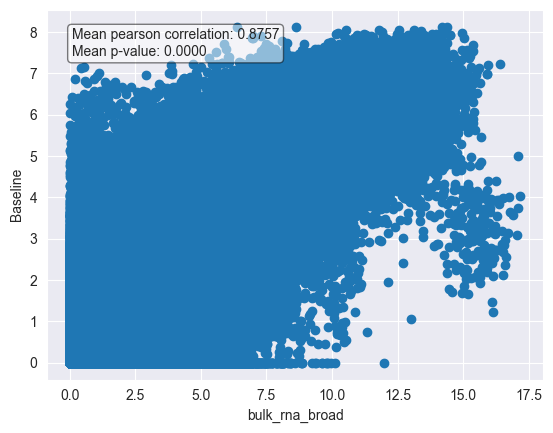

In [18]:
# Visualize the correlation of cell lines by scatter plot
cl_metadata.plot_correlation(
    base_line,
    corr=corr,
    pval=pvals,
    identifier="DepMap_ID",
    metadata_key="bulk_rna_broad",
    subset_identifier=None,
)

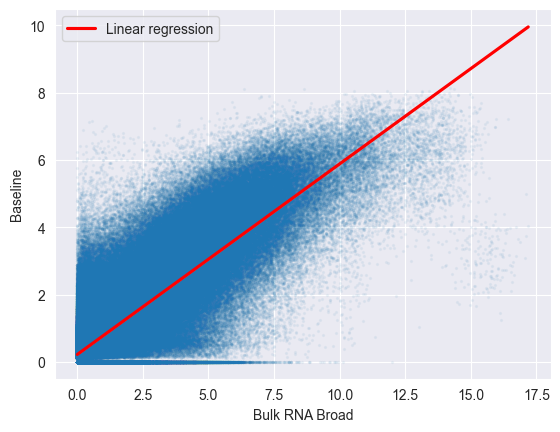

In [19]:
plot_df = pd.DataFrame(
    {
        "Bulk RNA Broad": base_line.obsm["bulk_rna_broad"].to_numpy().flatten(),
        "Baseline": base_line.X.flatten(),
    }
)

sns.regplot(
    x="Bulk RNA Broad",
    y="Baseline",
    data=plot_df,
    ci=99,
    scatter_kws={"s": 2, "alpha": 0.05},
    line_kws={"color": "red", "label": "Linear regression"},
)

plt.legend()

The correlation between the pseudobulks and the bulk RNA-seq data is quite high, indicating that the expression profiles of the cell lines in the McFarland dataset are similar to those in the bulk RNA-seq data.

## Deconvoluting drug responses

Above, we have annotated our dataset with GDSC IC50 values, indicating the drug response of each cell line to each drug. We can now use this information to deconvolute the drug response of each cell line into viability-dependent and -independent components.

In [20]:
adata.obs[["ln_ic50_GDSC1", "ln_ic50_GDSC2"]].corr()

,ln_ic50_GDSC1,ln_ic50_GDSC2
ln_ic50_GDSC1,1.000000,0.839123
ln_ic50_GDSC2,0.839123,1.000000


In [21]:
# Check for how many cell lines we have GDSC data (each cell line is expected to have a different GDSC score, except for the control)
adata.obs[["perturbation", "ln_ic50_GDSC2"]].drop_duplicates()["perturbation"].value_counts()

perturbation
Trametinib     115
Navitoclax      68
Dabrafenib      67
Afatinib        65
Gemcitabine     65
Taselisib       64
JQ1             63
Bortezomib      16
AZD5591          1
BRD3379          1
Everolimus       1
Idasanutlin      1
Prexasertib      1
control          1
Name: count, dtype: int64

We will look into the Trametinib drug response and deconvolute it into viability-dependent and -independent response, as shown in the [McFarland et al. 2020 paper](https://doi.org/10.1038/s41467-020-17440-w). We will use the EdgeR package for this analysis.

Precisely, we will perform the following steps:
1. Obtain log-fold changes (logFC) for each gene in each cell line treated with Trametinib compared to the control.
2. Perform linear regression between the logFC values and the GDSC IC50 values to obtain the slope and intercept for each gene.
3. Visualize the results in a volcano plot.

Let's start with the first step:

In [ ]:
adata_trametinib = adata[adata.obs["perturbation"].isin(["control", "Trametinib"])]

logfc_df = pd.DataFrame(columns=adata_trametinib.var_names)

for cell_line in tqdm(adata_trametinib.obs["SangerModelID"].unique()):
    
    subset = adata_trametinib[adata_trametinib.obs["SangerModelID"] == cell_line]
    if subset.n_obs < 20: #Threshold from the McFarland paper
        continue
    if "Trametinib" not in subset.obs["perturbation"].unique():
        continue
    
    edgr = pt.tl.EdgeR(subset, design="~perturbation", layer="raw_counts")
    edgr.fit()
    
    res_df = edgr.test_contrasts(edgr.contrast("perturbation", "control", "Trametinib"))
    res_df = res_df[["variable", "log_fc"]]
    res_df = res_df.set_index("variable")
    res_df = res_df.reindex(adata.var_names)
    
    logfc_df.loc[cell_line] = res_df["log_fc"]

logfc_df.to_csv(f"output/logfc_df_trametinib.csv")

In [24]:
logfc_df = pd.read_csv("output/logfc_df_trametinib.csv", index_col=0)
logfc_df = logfc_df.loc[:, (logfc_df != 0).any(axis=0)]

Now that we have the log-fold changes for each gene in each cell line treated with Trametinib, we can perform linear regression between the log-fold changes and the GDSC IC50 values to obtain the slope and intercept for each gene. We will use the GDSC1 dataset for this analysis, but you can also use the GDSC2 dataset by changing the `gdsc_dataset` parameter.

In [50]:
gdsc_dataset = 1 # We will use GDSC1 dataset for this analysis

lr_params = pd.DataFrame(columns=["gene", "slope", "intercept", "slope_pval", "intercept_pval"])
    
cell_lines = logfc_df.index
sens_cell_lines = adata_trametinib.obs[[f"ln_ic50_GDSC{gdsc_dataset}", "SangerModelID"]].drop_duplicates().dropna().set_index("SangerModelID")
cell_lines = [cell_line for cell_line in cell_lines if cell_line in sens_cell_lines.index]

X = sens_cell_lines.loc[cell_lines][f"ln_ic50_GDSC{gdsc_dataset}"].values
na_mask = np.isnan(X)
X = X[~na_mask]

for gene in tqdm(logfc_df.columns):
    y = logfc_df.loc[cell_lines][gene].values
    y = y[~na_mask]
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    
    lr_params.loc[gene] = [gene, results.params[1], results.params[0], results.pvalues[1], results.pvalues[0]]

#Filter out with both zero slope AND intercept
lr_params = lr_params[(lr_params["slope"] != 0) | (lr_params["intercept"] != 0)]

#Multiple testing correction
lr_params["slope_pval_corrected"] = sm.stats.multipletests(lr_params["slope_pval"], method="fdr_bh")[1]
lr_params["intercept_pval_corrected"] = sm.stats.multipletests(lr_params["intercept_pval"], method="fdr_bh")[1]
    
lr_params["-log10(slope_pval_corrected)"] = -np.log10(lr_params["slope_pval_corrected"])
lr_params["-log10(intercept_pval_corrected)"] = -np.log10(lr_params["intercept_pval_corrected"])

lr_params.to_csv(f"output/linear_regression_results_trametinib.csv")

100%|██████████| 4000/4000 [00:03<00:00, 1161.05it/s]


In [51]:
lr_params.head(5)

,gene,slope,intercept,slope_pval,intercept_pval,slope_pval_corrected,intercept_pval_corrected,-log10(slope_pval_corrected),-log10(intercept_pval_corrected)
RP11-206L10.2,RP11-206L10.2,-0.007334,0.008433,0.095789,4.975502e-01,0.456739,6.942729e-01,0.340332,0.158470
SAMD11,SAMD11,-0.084415,0.504378,0.003785,1.027966e-08,0.089069,2.797187e-07,1.050274,6.553279
HES4,HES4,-0.006969,0.217845,0.765093,1.340637e-03,0.931620,9.104494e-03,0.030761,2.040744
ISG15,ISG15,-0.074046,0.909752,0.005901,1.396257e-21,0.114586,6.205588e-19,0.940867,18.207217
RNF223,RNF223,0.010844,0.089340,0.442188,2.736844e-02,0.800528,1.029857e-01,0.096624,0.987223


In [52]:
def volcano_plot(lr_params, coeff, pval_threshold=0.05, value_threshold=0.5):
    assert coeff in ["slope", "intercept"]
    
    # Assign color based on p-value and effect size
    lr_params["color"] = "lightblue"
    lr_params.loc[(lr_params[coeff] > value_threshold) 
                  & (lr_params[f"{coeff}_pval_corrected"] < pval_threshold), "color"] = "red"
    lr_params.loc[(lr_params[coeff] < -value_threshold) 
                  & (lr_params[f"{coeff}_pval_corrected"] < pval_threshold), "color"] = "blue"
    
    lr_params["size"] = 1
    lr_params.loc[lr_params["color"].isin(["red", "blue"]), "size"] = 1.1
    
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.scatterplot(
        data=lr_params,
        x=coeff,
        y="-log10({}_pval_corrected)".format(coeff),
        hue="color",
        palette={"lightblue": "lightblue", "red": "#D2455E", "blue": "#34669A"},
        size="size",
        ax=ax,
    )
    
    sig_genes = lr_params[lr_params["color"].isin(["red", "blue"])].sort_values("-log10({}_pval_corrected)".format(coeff), ascending=False)[:15]
    for i, gene in enumerate(sig_genes.index):
        ax.text(sig_genes.loc[gene, coeff], sig_genes.loc[gene, "-log10({}_pval_corrected)".format(coeff)], gene, fontsize=8)
        
    ax.get_legend().remove()
    plt.show()

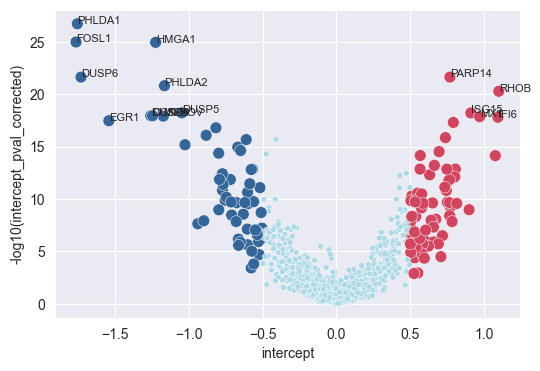

In [53]:
volcano_plot(lr_params, "intercept", pval_threshold=0.05, value_threshold=0.5)

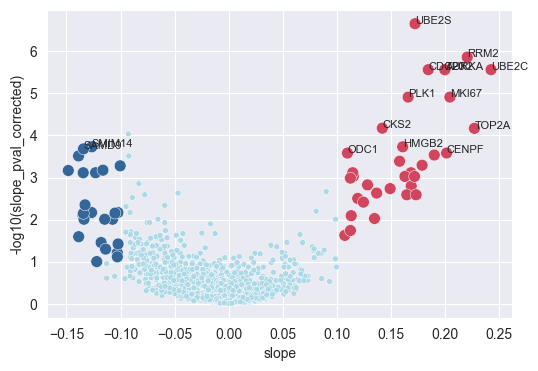

In [55]:
volcano_plot(lr_params, "slope", pval_threshold=0.1, value_threshold=0.1)